In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle
import h5py

In [3]:
sys.path.append("..")

from WatChMaL.analysis.multi_plot_utils import multi_disp_learn_hist, multi_compute_roc, multi_plot_roc
from WatChMaL.analysis.comparison_utils import multi_get_masked_data, multi_collapse_test_output
from WatChMaL.analysis.fitqun_comparison_utils import load_fq_output
from WatChMaL.analysis.performance_analysis_utils import plot_binned_performance, plot_fitqun_binned_performance, plot_multi_var_binned_performance, plot_binned_response

In [4]:
############# define plotting params #############
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
label_dict = {"$\gamma$":0, "$e$":1, "$\mu$":2}
inverse_label_dict = {0:"$\gamma$", 1:"$e$", 2:"$\mu$"}
muon_softmax_index_dict = {"e/gamma":0, "mu":1}

## Load fitqun results

In [5]:
# Retrieve flags
gamma_file_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_gamma_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
e_file_path     = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_e-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
mu_file_path    = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_mu-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'

In [6]:
fq_mapping_path = '/home/jtindall/WatChMaL_analysis/fitqun_comparison/fq_comparison_data/3M_fitqun_mapping.pickle'

In [7]:
fq_scores, fq_labels, fq_mom = load_fq_output(fq_mapping_path, gamma_file_path, e_file_path, mu_file_path)

In [8]:
print(fq_mom)

[206.95685 842.6756  233.17891 ... 361.7926  144.14459 717.5251 ]


## Load resnet results

In [9]:
############# define run locations #############
short_locs = ['/home/jtindall/WatChMaL/outputs/2021-03-16/20-21-15/outputs']

short_titles = ['Short Tank', 'Fitqun']

full_locs = []

full_titles = []

short_linecolor = [c[0] for _ in range(2)]
short_linestyle = ['--' for _ in range(2)]

full_linecolor = [c[1] for _ in full_locs]
full_linestyle = [':' for _ in full_locs]


In [10]:
############# load short tank run data #############
short_raw_output_softmax    = [np.load(loc + "/softmax.npy") for loc in short_locs]
short_raw_actual_labels     = [np.load(loc + "/labels.npy") for loc in short_locs]

In [11]:
locs      = short_locs + full_locs
titles    = short_titles + full_titles
linecolor = short_linecolor + full_linecolor
linestyle = short_linestyle + full_linestyle

## Add fitqun results

In [12]:
short_raw_output_softmax = short_raw_output_softmax + [fq_scores]
short_raw_actual_labels  = short_raw_actual_labels + [fq_labels]

## Filter results

In [13]:
def remove_indices(array, cut_idxs):
    return np.delete(array, cut_idxs, 0)

with open('./fq_comparison_data/3M_fitqun_cuts.pickle', 'rb') as handle:
    cuts = pickle.load(handle)

cut_to_apply = [] #cuts['fq_comparison']

In [14]:
short_softmax = [remove_indices(softmax, cut_to_apply) for softmax in short_raw_output_softmax]
short_labels  = [remove_indices(labels, cut_to_apply) for labels in short_raw_actual_labels]

## Load h5 Data

In [15]:
# Import test events from h5 file
data_path = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_emg_E0to1000MeV_digihits.h5"
data_file = h5py.File(data_path, "r")

print(data_file.keys())

energies   = np.array(data_file['energies'])
angles     = np.array(data_file['angles'])
positions  = np.array(data_file['positions'])
labels     = np.array(data_file['labels'])

<KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_charge', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>


In [16]:
idxs_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_3M_idxs.npz'
idxs = np.load(idxs_path, allow_pickle=True)

test_idxs  = idxs['test_idxs']

test_angles    = angles[test_idxs]
test_energies  = energies[test_idxs]
test_positions = positions[test_idxs]
test_labels    = labels[test_idxs]
test_info = {'name':'Test Set','energies':test_energies,'positions':test_positions, 'angles':test_angles, 'labels':test_labels}

print("Done test info")

Done test info


## Load Parameters

In [17]:
filtered_fq_mom = remove_indices(fq_mom, cut_to_apply)

In [18]:
d_to_wall = np.load('./fq_comparison_data/3M_d_to_wall.npz', allow_pickle=True)

test_d_to_wall  = d_to_wall['test_d_to_wall']

test_d_to_wall = remove_indices(test_d_to_wall, cut_to_apply)

In [19]:
true_mom = np.load('./fq_comparison_data/3M_momenta.npz', allow_pickle=True)

test_true_mom  = true_mom['test_momenta']

test_true_mom = remove_indices(test_true_mom, cut_to_apply)

In [20]:
print(test_energies.shape)

(3524482, 1)


In [21]:
filtered_test_energies  = remove_indices(test_energies, cut_to_apply)

In [22]:
# bin energy data
energy_hist, energy_bins = np.histogram(filtered_test_energies, bins=9)
print("Energy bins: ", energy_bins)

# bin d to wall data
d_to_wall_hist, d_to_wall_bins = np.histogram(test_d_to_wall, bins=9)
print("Distance to wall bins: ", d_to_wall_bins)


Energy bins:  [   1.4282632  130.18697    258.94568    387.70438    516.4631
  645.2218     773.98047    902.7392    1031.4979    1160.2566   ]
Distance to wall bins:  [3.27540543e-04 1.10083047e+02 2.20165767e+02 3.30248487e+02
 4.40331207e+02 5.50413927e+02 6.60496647e+02 7.70579367e+02
 8.80662087e+02 9.90744807e+02]


## Binned Performance Plots

### Plot To Wall Binned in Energy

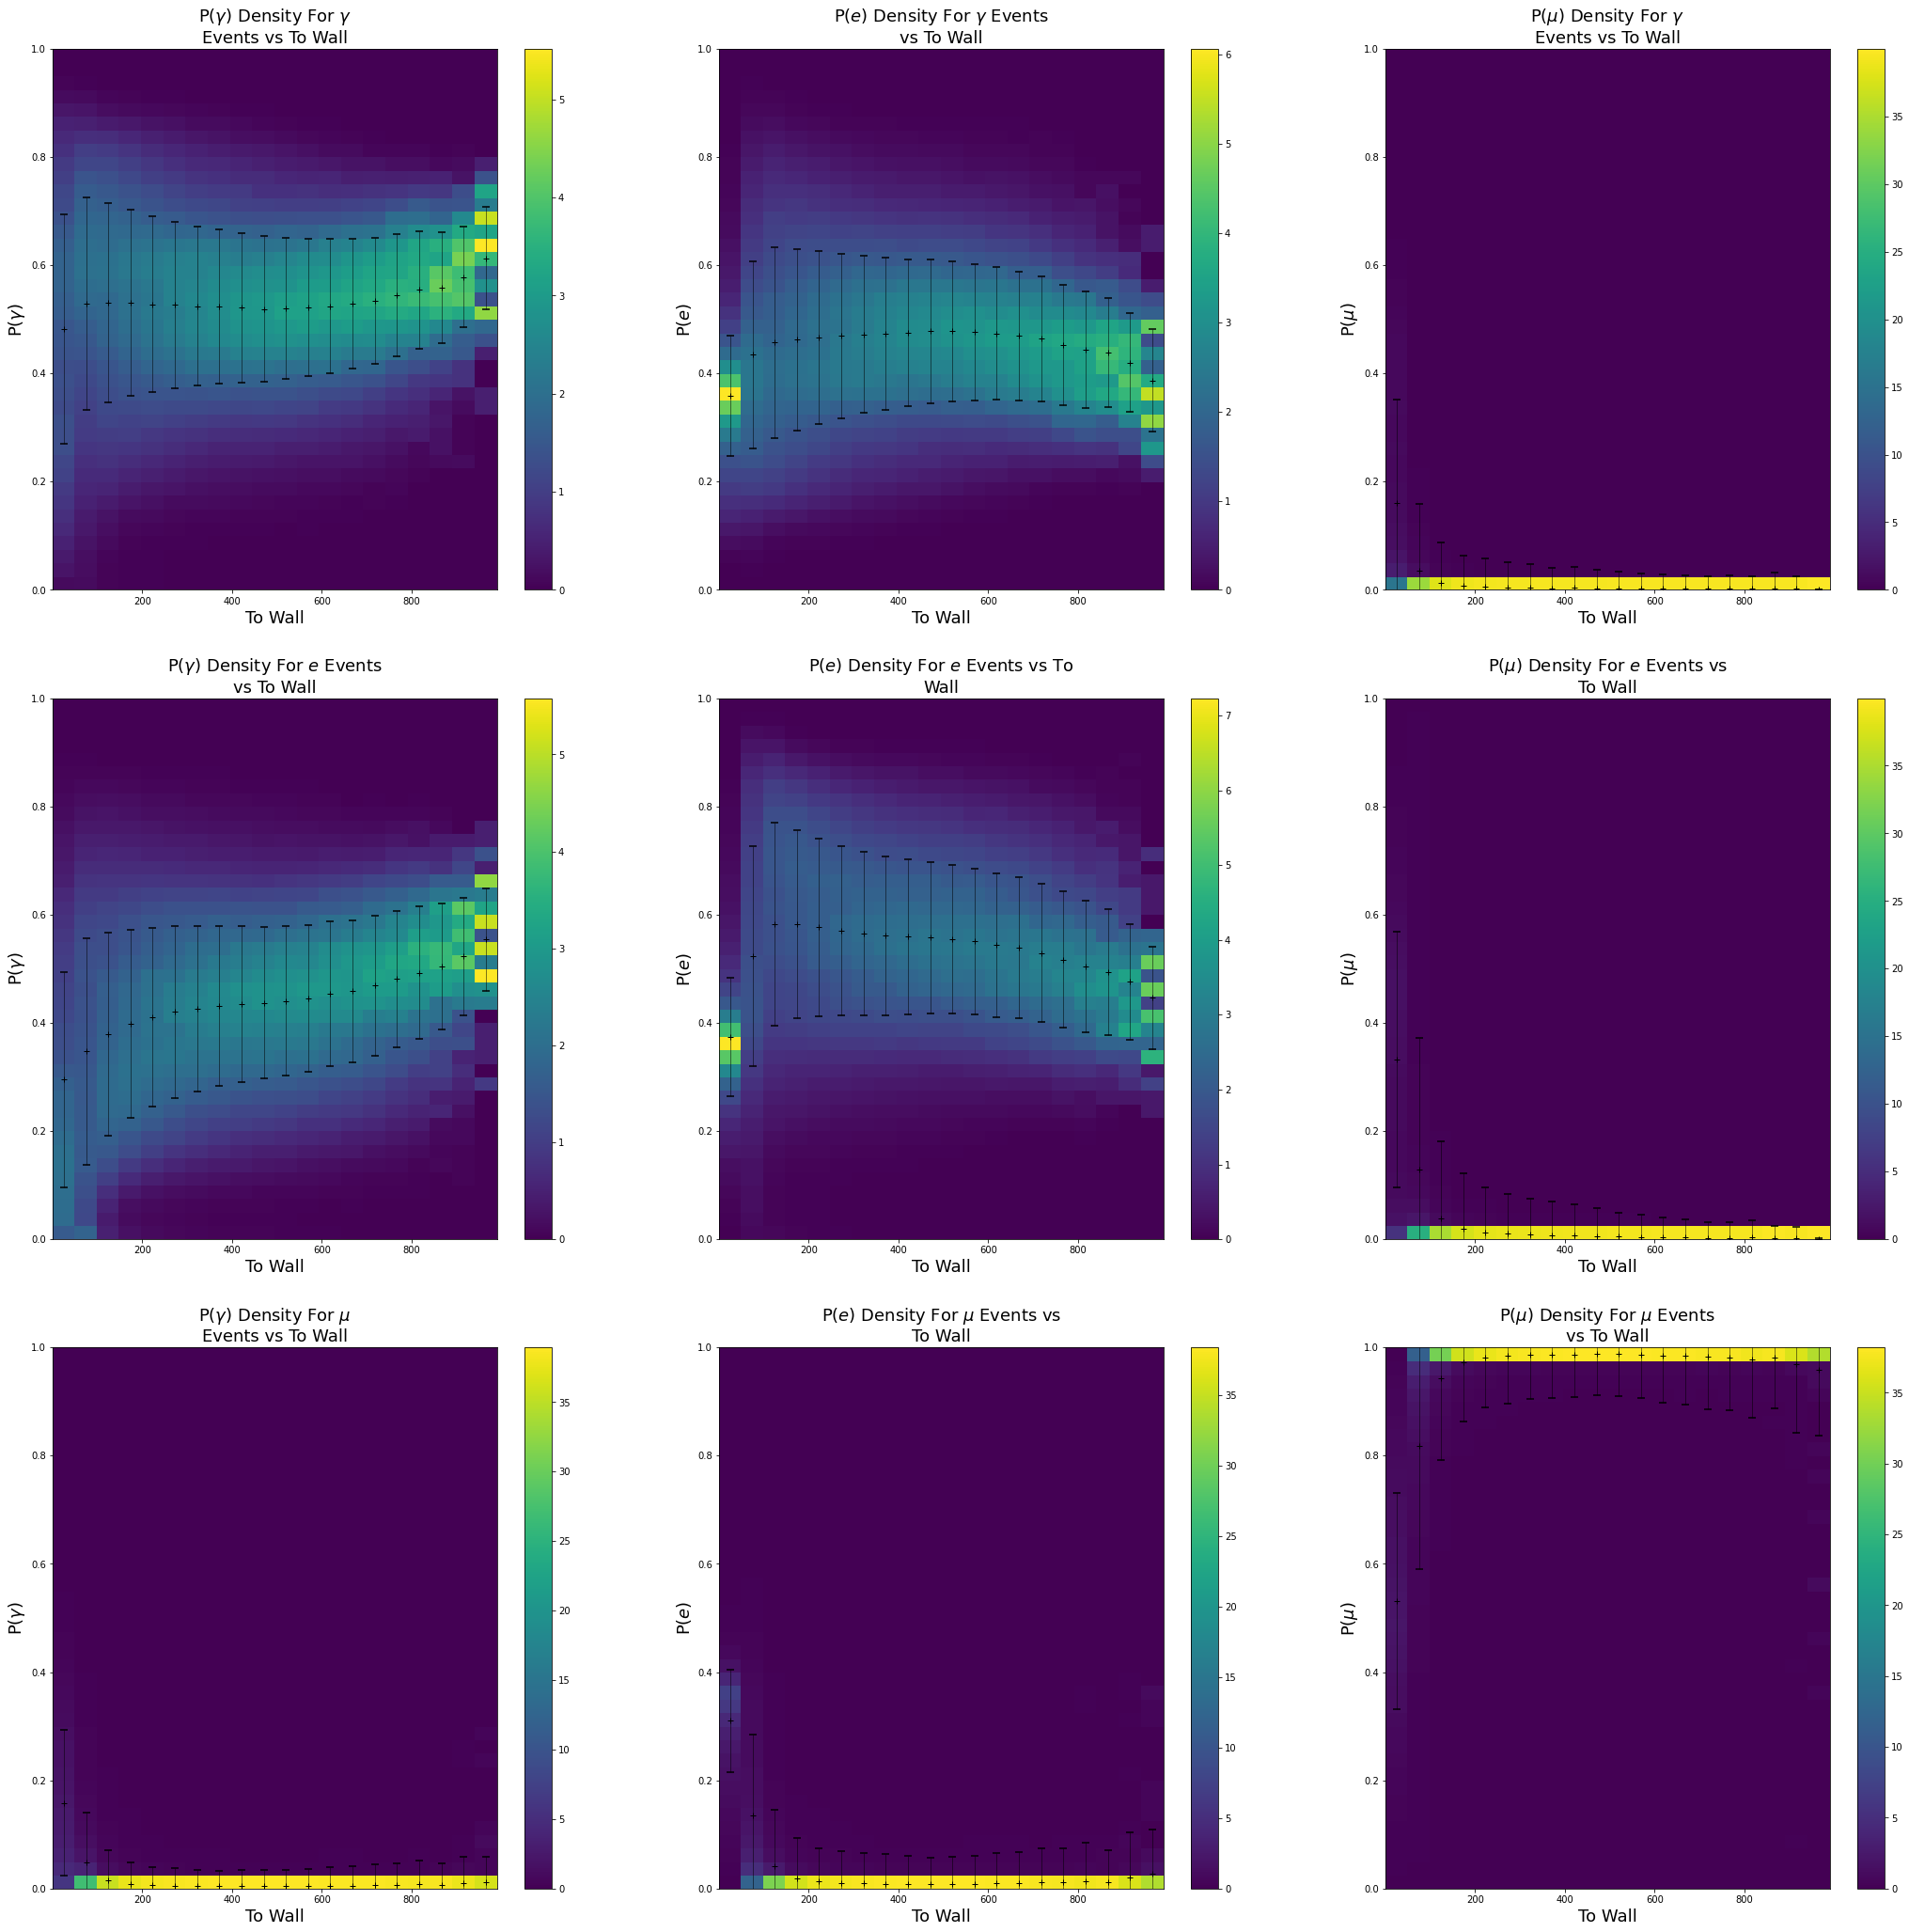

In [37]:
plot_binned_response(softmaxes = short_softmax[0], 
                     labels = short_labels[0], 
                     particle_names = ['$\gamma$','$e$','$\mu$'], 
                     binning_features = test_d_to_wall, 
                     binning_label = 'To Wall',
                     efficiency = 0.9, 
                     bins = 20, 
                     p_bins = 40, 
                     index_dict = label_dict, 
                     extra_panes=None, 
                     log_scales=[], 
                     legend_label_dict=None, 
                     wrap_size=35)

TypeError: 'AxesSubplot' object is not subscriptable

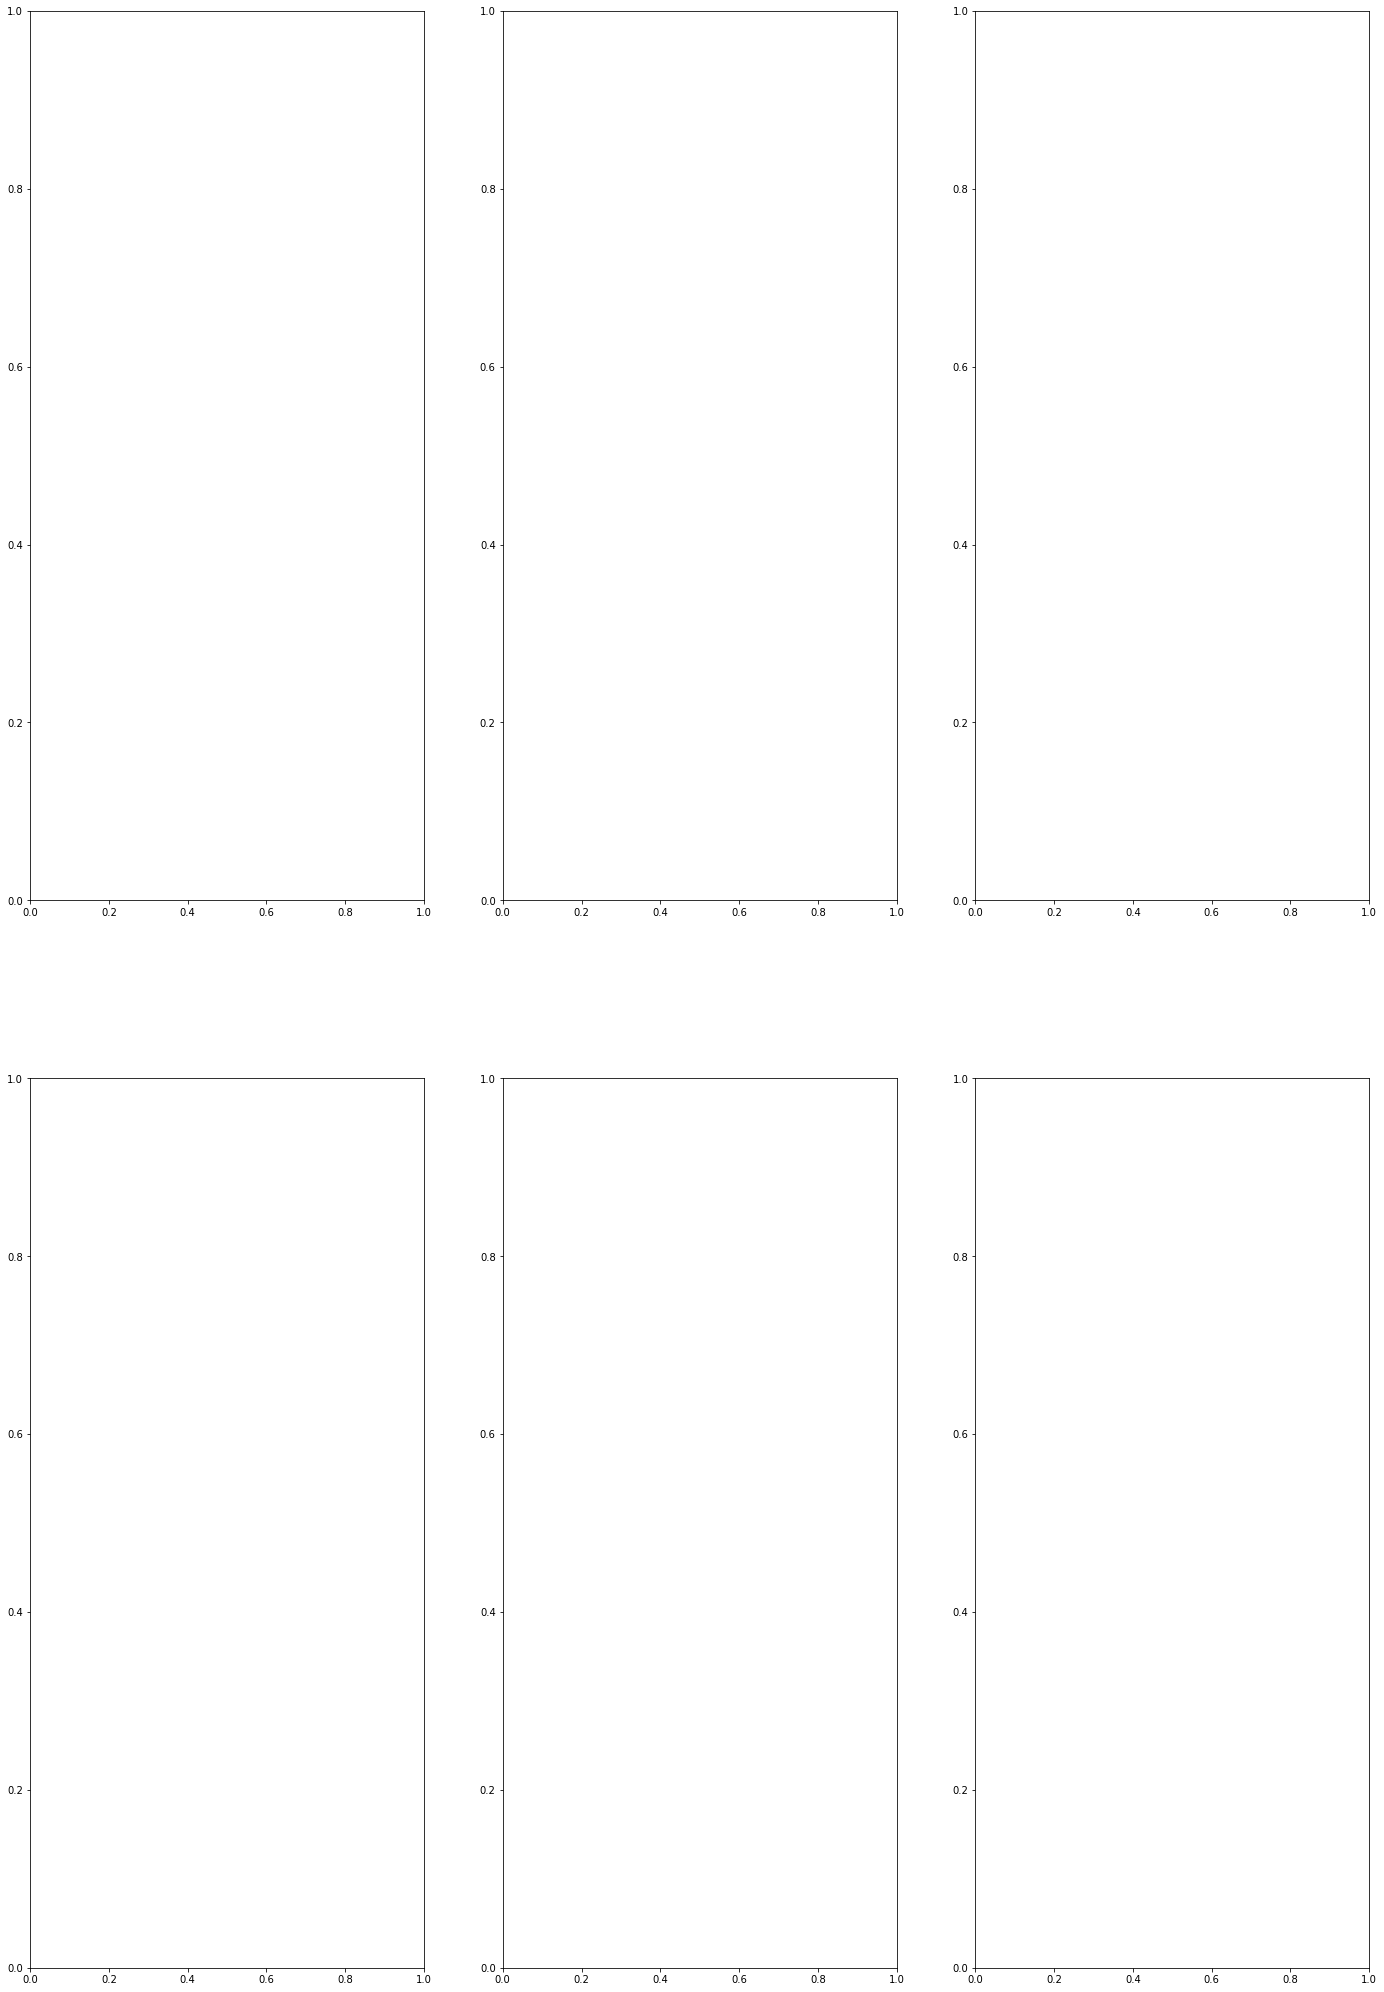

In [35]:
plot_binned_response(softmaxes = short_softmax[0], 
                     labels = short_labels[0], 
                     particle_names = ['$e$','$\mu$'], 
                     binning_features = test_d_to_wall, 
                     binning_label = 'To Wall',
                     efficiency = 0.9, 
                     bins = 20, 
                     p_bins = 40, 
                     index_dict = label_dict, 
                     extra_panes=None, 
                     log_scales=[], 
                     legend_label_dict=None, 
                     wrap_size=35)